In [1]:
import csv
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
os.chdir('/home/mckc/Downloads/data bases/emotions/')

In [2]:
labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
labels[0]

'Angry'

In [3]:
df = pd.read_csv('fer2013.csv')
df['pixels'] = df['pixels'].apply(lambda im: np.fromstring(im, sep=' '))
df.shape

(35887, 3)

In [4]:
train = (df.loc[df.Usage=='Training']).values[:,:2]
test = (df.loc[df.Usage!='Training']).values[:,:2]
print train.shape,test.shape,type(train)

(28709, 2) (7178, 2) <type 'numpy.ndarray'>


Angry


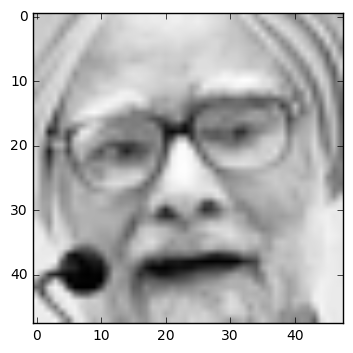

In [5]:
train[1,1].reshape(48,48)
print(labels[train[1,0]])
plt.imshow(train[1,1].reshape(48,48),cmap=cm.Greys_r)

In [6]:
X_tr= np.array([train[i,1] for i in range(train.shape[0])])
X_ts= np.array([test[i,1] for i in range(test.shape[0])])

In [7]:
X_normal = X_tr.reshape(-1,2304)
X_test_normal = X_ts.reshape(-1,2304)
Y_number = train[:,0].astype("|S6")
Y_test_number = test[:,0].astype("|S6")

In [8]:
Y_number.dtype

dtype('S6')

In [9]:
unique, counts = np.unique(Y_number, return_counts=True)
dict(zip(unique, counts))

{'0': 3995, '1': 436, '2': 4097, '3': 7215, '4': 4830, '5': 3171, '6': 4965}

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

clf = LogisticRegression(verbose=0,n_jobs=-1,multi_class='multinomial',solver='lbfgs',max_iter=100,warm_start=True)

/home/mckc/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
clf.fit(X_tr,Y_number)
Y_logictic= clf.predict(X_test_normal)

print 'Accuracy of the model is ',accuracy_score(Y_test_number,Y_logictic)
confusion_matrix(Y_test_number,Y_logictic)

Accuracy of the model is  0.372248537197


array([[ 150,    0,   73,  358,  142,   90,  145],
       [  15,    0,   16,   39,   13,    8,   20],
       [  83,    0,  136,  326,  155,  143,  181],
       [  81,    0,   65, 1264,  141,   77,  146],
       [ 127,    2,  101,  349,  279,  133,  256],
       [  34,    0,   73,  158,   90,  376,  100],
       [  86,    0,   64,  377,  149,   90,  467]])

In [12]:
from sklearn.ensemble import RandomForestClassifier
recognizer = RandomForestClassifier(200,verbose=0,oob_score=True,n_jobs=-1,warm_start=True)
#scores = cross_validation.cross_val_score(recognizer, X_normal, Y_number, cv=5)
#print scores
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [13]:
recognizer.fit(X_tr,Y_number)
Y_rf= recognizer.predict(X_test_normal)

print 'Accuracy of the model is ',accuracy_score(Y_test_number,Y_rf)
confusion_matrix(Y_test_number,Y_rf)

Accuracy of the model is  0.473251602118


array([[ 188,    0,   60,  367,  168,   39,  136],
       [   5,   33,    5,   44,   10,    4,   10],
       [  42,    0,  280,  299,  167,   85,  151],
       [  28,    0,   32, 1416,  139,   46,  113],
       [  48,    0,   78,  424,  450,   18,  229],
       [  12,    0,   50,  142,   35,  515,   77],
       [  23,    0,   46,  443,  181,   25,  515]])

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K
from keras.optimizers import Adam,SGD,RMSprop,Adadelta,Adagrad,Nadam,Adamax
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)


Y_Keras = np_utils.to_categorical(Y_number, 7)
Y_Keras_test = np_utils.to_categorical(Y_test_number,7)
# Create first network with Keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
model = Sequential()
model.add(Dense(1000, input_dim=2304,activation='relu'))
model.add(Dense(1000,activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(1000,activation='relu'))
model.add(Dense(7,activation='softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
rms = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
adagrad = Adagrad(lr=0.0001, epsilon=1e-08)
adadelta = Adadelta(lr=.1, rho=0.95, epsilon=1e-08)
adam = Adam(lr=0.00000001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
adamax= Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
nadam = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)


# Compile model
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.fit(X_tr, Y_Keras, nb_epoch=4000, batch_size=200,verbose=1,shuffle=True,
          validation_data=(X_ts,Y_Keras_test))

Y_ke= model.predict(X_test_normal)

print 'Accuracy of the model is ',accuracy_score(Y_test_number,Y_ke)
confusion_matrix(Y_test_number,Y_ke)

In [14]:
import lasagne
#from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayer
#from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayer
from lasagne import layers
from lasagne.objectives import categorical_crossentropy
from lasagne.updates import nesterov_momentum,adadelta
from nolearn.lasagne import BatchIterator,visualize,NeuralNet
Conv2DLayer = layers.Conv2DLayer
MaxPool2DLayer = layers.MaxPool2DLayer

net = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', Conv2DLayer),
        ('pool1', MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', Conv2DLayer),
        ('pool2', MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('conv3', Conv2DLayer),
        ('pool3', MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 48, 48),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,
    hidden4_num_units=1000,
    dropout4_p=0.5,
    hidden5_num_units=3000,
    output_nonlinearity=lasagne.nonlinearities.softmax,
    output_num_units=7,
    
    update = adadelta,
    update_learning_rate=0.01,
#    update_momentum=0.9,
    max_epochs=500,
    verbose=1
)

Using gpu device 0: Quadro M2000M (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5005)


In [15]:
net.fit(X_tr.reshape(-1,1,48,48).astype(np.float32), Y_number.astype(np.uint8))

/home/mckc/anaconda/lib/python2.7/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


# Neural Network with 6266479 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x48x48
  1  conv1     32x46x46
  2  pool1     32x23x23
  3  dropout1  32x23x23
  4  conv2     64x22x22
  5  pool2     64x11x11
  6  dropout2  64x11x11
  7  conv3     128x10x10
  8  pool3     128x5x5
  9  dropout3  128x5x5
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   3000
 13  output    7

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  -----
      1    10.45755     2.02761    5.15756      0.18576  8.64s
      2     3.12853     1.87660    1.66713      0.19342  8.64s
      3     2.09592     1.90245    1.10169      0.23259  8.63s
      4     1.90503     1.90761    0.99865      0.24739  8.63s
      5     1.87111     1.91446    0.97735      0.25226  8.64s
      6     1.85629     1.91350    0.97011      0.25157  8.64s
      7     1.84850     1.91204    0.96677      0.25122  8.64s


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f4235eb8690>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f4235eb8590>,
     check_input=True, conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_scores=None,
     dropout1_p=0.1, dropout2_p=0.2, dropout3_p=0.3, dropout4_p=0.5,
     hidden4_num_units=1000, hidden5_num_units=3000,
     input_shape=(None, 1, 48, 48),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('dropout1', <class 'lasagne.layers.noise.DropoutLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <cla..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,AveragePooling2D
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import Adam,SGD,Adadelta,Adagrad
from keras import backend as K
from keras.models import load_model

Y_Keras = np_utils.to_categorical(Y_number, 7)
Y_Keras_test = np_utils.to_categorical(Y_test_number,7)

model = Sequential()
model.add(Convolution2D(32, 3, 3,border_mode='same',input_shape=( 1, 48, 48),activation='relu'))
model.add(Convolution2D(64, 3, 3,border_mode='same',activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(64, 3, 3,border_mode='same',activation='relu'))
model.add(Convolution2D(128, 3, 3,border_mode='same',activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(96, 3, 3,border_mode='same',activation='relu'))
model.add(Convolution2D(192, 3, 3,border_mode='same',activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(128, 3, 3,border_mode='same',activation='relu'))
model.add(Convolution2D(256, 3, 3,border_mode='same',activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(160, 3, 3,border_mode='same',activation='relu'))
model.add(Convolution2D(320, 3, 3,border_mode='same',activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2), strides=(1,1)))

model.add(Flatten())
model.add(Dense(1000,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000,activation='relu'))
model.add(Dense(7,activation='softmax'))


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.load_weights("my_model.h5")


model.fit(X_tr.reshape(-1,1,48,48), Y_Keras, nb_epoch=1, batch_size=500,verbose=1,shuffle=True,
          validation_data=(X_ts.reshape(-1,1,48,48),Y_Keras_test))
model.save('my_model.h5')

Y_ke=  model.predict_classes(X_test_normal.reshape(-1,1,48,48))

print 'Accuracy of the model is ',accuracy_score(Y_test_number.astype(int),Y_ke)
confusion_matrix(Y_test_number.astype(int),Y_ke)

Train on 28709 samples, validate on 7178 samples
Epoch 1/1
7168/7178 [============================>.] - ETA: 0sAccuracy of the model is  0.4341042073


array([[  48,    0,   47,  143,  556,   62,  102],
       [   5,    0,    9,   12,   66,    3,   16],
       [  16,    0,  102,  182,  448,  181,   95],
       [   2,    0,   17, 1416,  269,   47,   23],
       [  30,    0,   58,  226,  780,   48,  105],
       [   2,    0,   85,   80,   82,  555,   27],
       [  34,    0,   66,  210,  675,   33,  215]])

In [16]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

datagen.fit(X_tr.reshape(-1,1,48,48))
model.fit_generator(datagen.flow(X_tr.reshape(-1,1,48,48), Y_Keras,
                    batch_size=300),
                    samples_per_epoch=80000,
                    nb_epoch=2,
                    validation_data=(X_ts.reshape(-1,1,48,48),Y_Keras_test))
model.save('my_model.h5')
#40000 best was 6.15 at 150
#80000 besy was 6.67 at 150
#180000 best was 6.68 at 50

Epoch 1/2
53009/80000 [==================>...........] - ETA: 68s - loss: 0.7263 - acc: 0.7341

KeyboardInterrupt: 

In [ ]:
import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression

network = input_data(shape=[None, 48, 48, 1], name='input')
network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")
network = max_pool_2d(network, 2)
network = local_response_normalization(network)
network = conv_2d(network, 64, 3, activation='relu', regularizer="L2")
network = max_pool_2d(network, 2)
network = local_response_normalization(network)
network = fully_connected(network, 128, activation='tanh')
network = dropout(network, 0.8)
network = fully_connected(network, 256, activation='tanh')
network = dropout(network, 0.8)
network = fully_connected(network, 7, activation='softmax')
network = regression(network, optimizer='adam', learning_rate=0.01,
                     loss='categorical_crossentropy', name='target')

# Training
model = tflearn.DNN(network, tensorboard_verbose=0)
model.fit({'input': X_tr.reshape(-1,1,48,48)}, {'target': Y_number}, n_epoch=20,
           validation_set=({'input': X_ts.reshape(-1,1,48,48)}, {'target': Y_test_number}),
snapshot_step=100, show_metric=True, run_id='convnet_mnist')

In [42]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import SimpleRNN
from keras.initializations import normal, identity
from keras.optimizers import RMSprop
from keras.utils import np_utils

max_features = 20000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

model = Sequential()
model.add(SimpleRNN(output_dim=100,
                    init=lambda shape, name: normal(shape, scale=0.001, name=name),
                    inner_init=lambda shape, name: identity(shape, scale=1.0, name=name),
                    activation='relu',
                    input_shape=(X_tr.reshape(-1,48,48)).shape[1:]))
model.add(Dense(7))
model.add(Activation('softmax'))

adam = Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#model.load_weights("model.h5")

model.fit(X_tr.reshape(-1,48,48), Y_Keras, nb_epoch=40, batch_size=200,verbose=1,shuffle=True,
          validation_data=(X_ts.reshape(-1,48,48),Y_Keras_test))

Y_ke= model.predict(X_ts.reshape(-1,48,48))

print 'Accuracy of the model is ',accuracy_score(Y_test_number,Y_ke)
confusion_matrix(Y_test_number,Y_ke)

scores = model.evaluate(X_test_normal, Y_test_number, verbose=0)
print('IRNN test score:', scores[0])
print('IRNN test accuracy:', scores[1])

Train on 28709 samples, validate on 7178 samples
Epoch 1/40
28709/28709 [==============================] - 2s - loss: 7.6460 - acc: 0.1690 - val_loss: 5.1133 - val_acc: 0.1722
Epoch 2/40
28709/28709 [==============================] - 2s - loss: 3.9249 - acc: 0.1931 - val_loss: 3.4450 - val_acc: 0.2021
Epoch 3/40
28709/28709 [==============================] - 2s - loss: 3.2373 - acc: 0.2000 - val_loss: 3.0967 - val_acc: 0.2027
Epoch 4/40
28709/28709 [==============================] - 2s - loss: 2.9779 - acc: 0.2047 - val_loss: 2.9192 - val_acc: 0.1995
Epoch 5/40
28709/28709 [==============================] - 2s - loss: 2.8003 - acc: 0.2098 - val_loss: 2.7254 - val_acc: 0.2165
Epoch 6/40
28709/28709 [==============================] - 2s - loss: 2.6866 - acc: 0.2125 - val_loss: 2.6156 - val_acc: 0.2106
Epoch 7/40
28709/28709 [==============================] - 2s - loss: 2.6085 - acc: 0.2136 - val_loss: 2.5814 - val_acc: 0.1925
Epoch 8/40
28709/28709 [==============================] - 2s -

ValueError: Can't handle mix of multiclass and continuous-multioutput

In [47]:
unique, counts = np.unique(Y_ke.astype(int), return_counts=True)
dict(zip(unique, counts))

{0: 50246}